In [1]:
import sys
print(sys.executable)


/Users/m.pratyush/Desktop/code project/lstm_env/bin/python


In [2]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

/Users/m.pratyush/Desktop/code project/lstm_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# ------------- CONFIG -------------
DATA_PATH = "diabetes_prediction_dataset.csv"  # <<-- update this path
OUT_MODEL = "lstm_diabetes_model.h5"
OUT_SCALER = "lstm_diabetes_scaler.joblib"
OUT_HISTORY = "lstm_training_history.png"
OUT_CM = "lstm_confusion_matrix.png"
RANDOM_STATE = 42
EPOCHS = 80
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15

In [4]:
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (100000, 9)


In [5]:
# 2) Detect target column
possible_targets = ['Diabetic','Outcome','diabetes','diabetic','class','target','readmitted']
target_col = next((c for c in possible_targets if c in df.columns), df.columns[-1])
print("Detected target column:", target_col)

Detected target column: diabetes


In [6]:
# 3) Drop id-like cols
id_like = [c for c in df.columns if c.lower() in ['id','patientid','patient_id','encounter_id','encounterid']]
if id_like:
    df = df.drop(columns=id_like)
    print("Dropped ID-like columns:", id_like)

In [7]:
# 4) Basic imputation + encoding
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols and c != target_col]


In [8]:
# Encode target if needed
if df[target_col].dtype == object or df[target_col].dtype.name == 'category':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col].astype(str))
    print("Encoded target classes:", list(le_target.classes_))


In [9]:

# Fill missing
for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in categorical_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

In [10]:
# One-hot for small-cardinality categoricals
max_ohe = 20
ohe_cols = [c for c in categorical_cols if df[c].nunique() <= max_ohe]
if ohe_cols:
    df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)
    print("One-hot encoded:", ohe_cols)

One-hot encoded: ['gender', 'smoking_history']


In [11]:
# Label-encode any remaining categorical columns
remaining_cat = [c for c in categorical_cols if c not in ohe_cols]
for c in remaining_cat:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [12]:
# 5) Prepare features and labels
features = [c for c in df.columns if c != target_col]
X = df[features].values.astype(np.float32)
y = df[target_col].values.astype(np.int32)
print("Feature count:", X.shape[1])

Feature count: 13


In [13]:
# 6) Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:

# 7) Reshape for LSTM
# We'll treat each original feature as a timestep with 1 feature/channel
# Shape: (samples, timesteps, features_per_timestep) -> here features_per_timestep=1
X_lstm = X.reshape((X.shape[0], X.shape[1], 1))
print("LSTM input shape:", X_lstm.shape)

LSTM input shape: (100000, 13, 1)


In [15]:
# 8) Train/test split (stratify if classification)
if len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=RANDOM_STATE)


In [16]:
# 9) Build model
num_timesteps = X_train.shape[1]
num_classes = len(np.unique(y))
print("Num timesteps:", num_timesteps, "Num classes:", num_classes)

Num timesteps: 13 Num classes: 2


In [17]:
# For binary classification, final unit is 1 with sigmoid; for multi-class use softmax
def build_lstm_model():
    inp = layers.Input(shape=(num_timesteps, 1))
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    if num_classes > 2:
        out = layers.Dense(num_classes, activation='softmax')(x)
    else:
        out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_lstm_model()
loss = 'sparse_categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=loss, metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 13, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,817 (1.17 MB)

 Trainable params: 306,305 (1.17 MB)

 Non-trainable params: 512 (2.00 KB)

In [18]:

# 10) Optional: compute class weights (helps if classes are imbalanced)
from sklearn.utils.class_weight import compute_class_weight
if num_classes == 2:
    classes = np.unique(y_train)
    class_weights = dict(enumerate(compute_class_weight('balanced', classes=classes, y=y_train)))
    print("Class weights:", class_weights)
else:
    class_weights = None

Class weights: {0: np.float64(0.546448087431694), 1: np.float64(5.882352941176471)}


In [19]:
# 11) Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)


In [20]:
# 12) Train
history = model.fit(
    X_train, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/80
2125/2125 - 41s - 19ms/step - accuracy: 0.8529 - loss: 0.3216 - val_accuracy: 0.9026 - val_loss: 0.2325 - learning_rate: 1.0000e-03
Epoch 2/80
2125/2125 - 39s - 18ms/step - accuracy: 0.8711 - loss: 0.2689 - val_accuracy: 0.8721 - val_loss: 0.2786 - learning_rate: 1.0000e-03
Epoch 3/80
2125/2125 - 38s - 18ms/step - accuracy: 0.8714 - loss: 0.2439 - val_accuracy: 0.8792 - val_loss: 0.2429 - learning_rate: 1.0000e-03
Epoch 4/80
2125/2125 - 37s - 17ms/step - accuracy: 0.8824 - loss: 0.2266 - val_accuracy: 0.8709 - val_loss: 0.2305 - learning_rate: 1.0000e-03
Epoch 5/80
2125/2125 - 38s - 18ms/step - accuracy: 0.8814 - loss: 0.2186 - val_accuracy: 0.8792 - val_loss: 0.2357 - learning_rate: 1.0000e-03
Epoch 6/80
2125/2125 - 37s - 17ms/step - accuracy: 0.8800 - loss: 0.2127 - val_accuracy: 0.8708 - val_loss: 0.2187 - learning_rate: 1.0000e-03
Epoch 7/80
2125/2125 - 37s - 17ms/step - accuracy: 0.8772 - loss: 0.2073 - val_accuracy: 0.8659 - val_loss: 0.2027 - learning_rate: 1.0000e-03

In [21]:
model.save(OUT_MODEL)
joblib.dump(scaler, OUT_SCALER)
print(f"Saved model to {OUT_MODEL} and scaler to {OUT_SCALER}")

Saved model to lstm_diabetes_model.h5 and scaler to lstm_diabetes_scaler.joblib


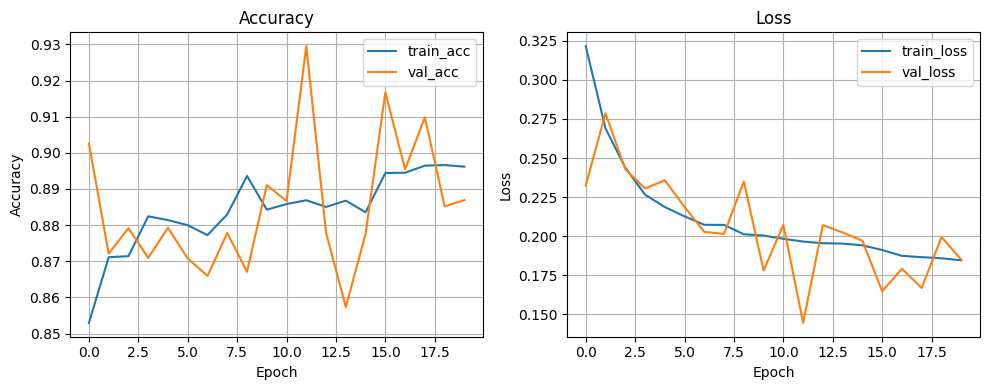

Saved training history plot to lstm_training_history.png


In [22]:
# Training history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='train_acc')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(OUT_HISTORY, dpi=200)
plt.show()
print(f"Saved training history plot to {OUT_HISTORY}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


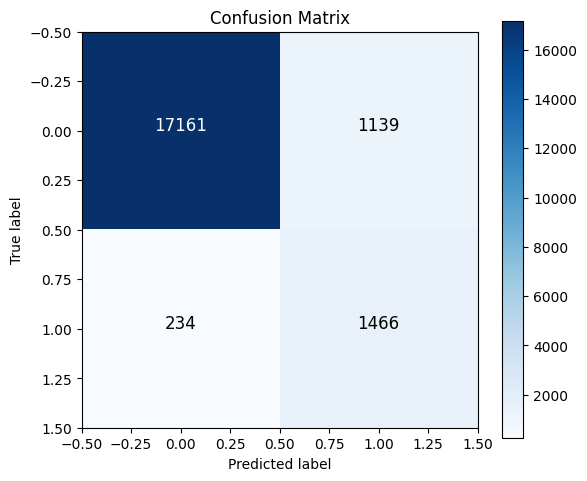

Saved confusion matrix plot to lstm_confusion_matrix.png
Done ✅ — LSTM model trained and saved. You can load it with tf.keras.models.load_model(OUT_MODEL).


In [23]:
# Compute predictions and confusion matrix
y_pred_prob = model.predict(X_test)
if num_classes == 2:
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)

# Confusion matrix heatmap (fixed colorbar)
plt.figure(figsize=(6,5))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar(im)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
plt.tight_layout()
plt.savefig(OUT_CM, dpi=200)
plt.show()
print(f"Saved confusion matrix plot to {OUT_CM}")

print("Done ✅ — LSTM model trained and saved. You can load it with tf.keras.models.load_model(OUT_MODEL).")

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Make sure X_test and y_test are defined and the model is already trained

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if y_pred_proba.ndim > 1 else (y_pred_proba > 0.5).astype(int)

# Convert y_test to labels if needed
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"LSTM Test Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
LSTM Test Accuracy:  0.9150
Precision: 0.8372
Recall:    0.9150
F1 Score:  0.8744
